<a href="https://colab.research.google.com/github/Fjoelsak/pong-from-pixels/blob/THM-workshop/scripts/THM_PongFromPixels_PolicyGradient_KerasSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RL Algo with tensorflow

In [12]:
!pip install -q gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -q -y xvfb python-opengl ffmpeg > /dev/null 2>&1

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import base64

import numpy as np
import pickle as pickle

import gym
from gym import wrappers
from gym.wrappers import Monitor

# IO
from pathlib import Path

In [13]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    html = []
    for mp4 in Path("video").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 300px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [14]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from matplotlib import animation
import gym

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.optimizers import rmsprop
import keras.backend as K


%matplotlib inline

In [4]:
env = gym.make("Pong-v0")

In [5]:
action_space = [4,5] #[No-op, up, down]

In [6]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3,3), padding='same', activation='relu', input_shape = (80,80,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(12, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(len(action_space), activation='softmax'))
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') #

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 12)        876       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 12)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)       

In [7]:
def preprocess(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)[:,:,None]

In [8]:
gamma = 0.99
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(discounted_r))):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add =  r[t] + running_add * gamma # belman equation
        discounted_r[t] = running_add
    return discounted_r

def discount_n_standardise(r):
    dr = discount_rewards(r)
    dr = (dr - dr.mean()) / dr.std()
    return dr

In [9]:
episodes = 0
n_episodes = 1000
reward_sums = np.zeros(n_episodes)
losses = np.zeros(n_episodes)
time_taken = np.zeros(n_episodes)
reward_sum = 0
im_shape = (80, 80, 1)

prev_frame = None
buffer = 1000
xs = np.zeros((buffer,)+im_shape)
ys = np.zeros((buffer,1))
rs = np.zeros((buffer))

k = 0

observation = env.reset()

while episodes < n_episodes:
    # Get the current state of environment
    x = preprocess(observation)
    xs[k] = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    prev_frame = x
    
    # Take an action given current state of policy model
    p = model.predict(xs[k][None,:,:,:])
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    ys[k] = a
    
    # Renew state of environment
    observation, reward, done, _ = env.step(action)
    reward_sum += reward #record total rewards
    rs[k] = reward # record reward per step
    
    k += 1
    
    if done or k==buffer:
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        # Gather state, action (y), and rewards (and preprocess)
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        ep_r = discount_n_standardise(ep_r)
        
        model.fit(ep_x, ep_y, sample_weight=ep_r, batch_size=512, epochs=1, verbose=0)
        
        time_taken[episodes] = k
        k = 0
        prev_frame = None
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, 
                                          ep_y,
                                          sample_weight=ep_r,
                                          batch_size=len(ep_x), 
                                          verbose=0)
        episodes += 1
        
        # Print out metrics like rewards, how long each episode lasted etc.
        if episodes%(n_episodes//20) == 0:
            ave_reward = np.mean(reward_sums[max(0,episodes-200):episodes])
            ave_loss = np.mean(losses[max(0,episodes-200):episodes])
            ave_time = np.mean(time_taken[max(0,episodes-200):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, ave_loss, ave_reward, ave_time))

Episode: 50, Average Loss: -0.0051, Average Reward: -19.7800, Average steps: 861.0000
Episode: 100, Average Loss: -0.0040, Average Reward: -19.1700, Average steps: 903.2500
Episode: 150, Average Loss: -0.0051, Average Reward: -19.0400, Average steps: 915.8200
Episode: 200, Average Loss: -0.0056, Average Reward: -18.6950, Average steps: 928.5450
Episode: 250, Average Loss: -0.0051, Average Reward: -17.9500, Average steps: 955.3750
Episode: 300, Average Loss: -0.0083, Average Reward: -17.7150, Average steps: 962.6800
Episode: 350, Average Loss: -0.0105, Average Reward: -16.9450, Average steps: 973.5650
Episode: 400, Average Loss: -0.0115, Average Reward: -16.4700, Average steps: 977.3050
Episode: 450, Average Loss: -0.0133, Average Reward: -16.2800, Average steps: 980.4850
Episode: 500, Average Loss: -0.0114, Average Reward: -15.5950, Average steps: 984.0000
Episode: 550, Average Loss: -0.0122, Average Reward: -15.2900, Average steps: 987.4400
Episode: 600, Average Loss: -0.0142, Average

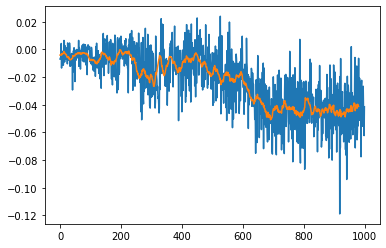

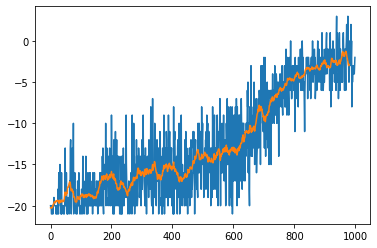

In [15]:
window = 20
plt.plot(losses[:episodes])
plt.plot(np.convolve(losses[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()

plt.plot(reward_sums[:episodes])
plt.plot(np.convolve(reward_sums[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()

In [17]:
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False

while not done:
    x = preprocess(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    obs, reward, done, info = env.step(action)

env.close()
show_video()

In [ ]:
episodes = 1000
n_episodes = 2000
reward_sums = np.zeros(n_episodes)
losses = np.zeros(n_episodes)
time_taken = np.zeros(n_episodes)
reward_sum = 0
im_shape = (80, 80, 1)

prev_frame = None
buffer = 1000
xs = np.zeros((buffer,)+im_shape)
ys = np.zeros((buffer,1))
rs = np.zeros((buffer))

k = 0

observation = env.reset()

while episodes < n_episodes:
    # Get the current state of environment
    x = preprocess(observation)
    xs[k] = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    prev_frame = x
    
    # Take an action given current state of policy model
    p = model.predict(xs[k][None,:,:,:])
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    ys[k] = a
    
    # Renew state of environment
    observation, reward, done, _ = env.step(action)
    reward_sum += reward #record total rewards
    rs[k] = reward # record reward per step
    
    k += 1
    
    if done or k==buffer:
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        # Gather state, action (y), and rewards (and preprocess)
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        ep_r = discount_n_standardise(ep_r)
        
        model.fit(ep_x, ep_y, sample_weight=ep_r, batch_size=512, epochs=1, verbose=0)
        
        time_taken[episodes] = k
        k = 0
        prev_frame = None
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, 
                                          ep_y,
                                          sample_weight=ep_r,
                                          batch_size=len(ep_x), 
                                          verbose=0)
        episodes += 1
        
        # Print out metrics like rewards, how long each episode lasted etc.
        if episodes%(n_episodes//20) == 0:
            ave_reward = np.mean(reward_sums[max(0,episodes-200):episodes])
            ave_loss = np.mean(losses[max(0,episodes-200):episodes])
            ave_time = np.mean(time_taken[max(0,episodes-200):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, ave_loss, ave_reward, ave_time))

Episode: 1100, Average Loss: -0.0230, Average Reward: -0.8600, Average steps: 500.0000
Episode: 1200, Average Loss: -0.0425, Average Reward: -1.5700, Average steps: 1000.0000
Episode: 1300, Average Loss: -0.0405, Average Reward: -1.0950, Average steps: 1000.0000
Episode: 1400, Average Loss: -0.0389, Average Reward: -1.1100, Average steps: 1000.0000
Episode: 1500, Average Loss: -0.0343, Average Reward: -1.3200, Average steps: 1000.0000


In [ ]:
window = 20
plt.plot(losses[:episodes])
plt.plot(np.convolve(losses[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()

plt.plot(reward_sums[:episodes])
plt.plot(np.convolve(reward_sums[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()

In [ ]:
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False

while not done:
    x = preprocess(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    obs, reward, done, info = env.step(action)

env.close()
show_video()